# Drone Target Estimation

## Downloads

### Download images

In [ ]:
!gdown --id 1AVzdmDYOSsMl6i3RZyipFxYXSk-PzjIk --output thirtysix.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AVzdmDYOSsMl6i3RZyipFxYXSk-PzjIk
From (redirected): https://drive.google.com/uc?id=1AVzdmDYOSsMl6i3RZyipFxYXSk-PzjIk&confirm=t&uuid=9b58d9ef-5250-4120-a562-6b5cd256225b
To: /content/thirtysix.zip
100% 738M/738M [00:12<00:00, 57.3MB/s]


In [ ]:
!unzip -q thirtysix.zip

### Download csv files

In [ ]:
!gdown --id 1N1suBCEP3K5EFM_vew9uiQ-3lQoIpvc3 --output drone_metadata.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1N1suBCEP3K5EFM_vew9uiQ-3lQoIpvc3
To: /content/drone_metadata.csv
100% 13.1k/13.1k [00:00<00:00, 38.1MB/s]


## Installs and imports



In [ ]:
!pip install googlemaps

  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40714 sha256=7f11ae11a6b9e00e768496285c8e05b5bc596c41759699dcb1e0605816af40ce
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
Successfully built googlemaps


In [ ]:
import os
import math
import pandas as pd
import requests
import googlemaps
import re
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from geopy.distance import distance, geodesic
from geopy.point import Point

## Methods

### Query Google Maps Elevation API for a single lat/lon point.

In [ ]:
def get_google_elevation(lat, lon, api_key):
    """Query Google Maps Elevation API for a single lat/lon point."""
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    params = {
        "locations": f"{lat},{lon}",
        "key": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200 and data["status"] == "OK":
        elevation = data["results"][0]["elevation"]
        return elevation
    else:
        raise Exception(f"Elevation API error: {data.get('status')} - {data.get('error_message', '')}")

### Extract the GPS metadata from the image

In [ ]:
def get_exif_data(image_path):
    image = Image.open(image_path)
    exif_data = image._getexif()
    if not exif_data:
        return {}
    exif = {}
    for tag, value in exif_data.items():
        tag_name = TAGS.get(tag, tag)
        exif[tag_name] = value
    return exif

def get_gps_info(exif):
    gps_info = {}
    if "GPSInfo" not in exif:
        return None
    for key in exif["GPSInfo"].keys():
        name = GPSTAGS.get(key, key)
        gps_info[name] = exif["GPSInfo"][key]
    return gps_info

def dms_to_dd(dms, ref):
    # Convert each D/M/S component directly to float
    degrees = float(dms[0])
    minutes = float(dms[1])
    seconds = float(dms[2])
    dd = degrees + (minutes / 60.0) + (seconds / 3600.0)
    return -dd if ref in ['S', 'W'] else dd

def extract_metadata(image_path):
    exif = get_exif_data(image_path)
    gps = get_gps_info(exif)
    if gps is None:
        return None

    lat = dms_to_dd(gps['GPSLatitude'], gps['GPSLatitudeRef'])
    lon = dms_to_dd(gps['GPSLongitude'], gps['GPSLongitudeRef'])
    alt = float(gps.get('GPSAltitude', 0))

    heading = float(gps.get('GPSImgDirection', 0))
    gimbal_pitch = -60.0  # still using a placeholder

    return {
        'lat': lat,
        'lon': lon,
        'altitude': alt,
        'heading': heading,
        'gimbal_pitch': gimbal_pitch
    }

### estimate_real_coords

In [ ]:
def estimate_real_coords(drone_lat, drone_lon, altitude, heading, gimbal_pitch, x_pixel, y_pixel, image_width, image_height, hfov, vfov):

    # Calculate delta angles
    delta_azimuth = ((x_pixel - image_width / 2) / (image_width / 2)) * (hfov / 2)
    delta_elevation = ((image_height / 2 - y_pixel) / (image_height / 2)) * (vfov / 2)

    total_pitch = gimbal_pitch + delta_elevation
    if total_pitch >= 0 or total_pitch <= -120:
        raise ValueError(f"Invalid pitch: {total_pitch}°")

    # Normalize heading to 0-360 and compute total azimuth
    normalized_heading = heading % 360  # Converts -180-180 to 0-360
    total_azimuth = (normalized_heading + delta_azimuth) % 360

    # Calculate distance to target
    total_pitch_rad = math.radians(total_pitch)
    line_of_sight = altitude / math.sin(-total_pitch_rad)
    horizontal_distance = line_of_sight * math.cos(total_pitch_rad)

    # Compute new coordinates
    drone_point = Point(drone_lat, drone_lon)
    target_point = distance(meters=horizontal_distance).destination(drone_point, total_azimuth)
    return (target_point.latitude, target_point.longitude)

class TargetTracker:
    def __init__(self, distance_threshold=5.0):
        self.targets = []
        self.current_id = 0
        self.distance_threshold = distance_threshold  # meters

    def add_target(self, lat, lon):
        new_point = (lat, lon)
        min_dist = float('inf')
        min_id = None

        for target_id, t_lat, t_lon in self.targets:
            dist = geodesic((t_lat, t_lon), new_point).meters
            if dist < min_dist:
                min_dist = dist
                min_id = target_id

        if min_dist <= self.distance_threshold:
            return min_id
        else:
            self.targets.append((self.current_id, lat, lon))
            self.current_id += 1
            return self.current_id - 1

### Sampling multiple points around the target point

In [ ]:
def get_smoothed_elevation(lat, lon, api_key, sample_distance=50):
    gmaps = googlemaps.Client(key=api_key)

    delta_lat = sample_distance / 111320.0
    delta_lon = sample_distance / (111320.0 * math.cos(math.radians(lat)))

    # Use center + N/S/E/W only
    sample_points = [
        (lat, lon),                    # Center
        (lat + delta_lat, lon),         # North
        (lat - delta_lat, lon),         # South
        (lat, lon + delta_lon),         # East
        (lat, lon - delta_lon),         # West
    ]

    try:
        results = gmaps.elevation(sample_points)
        elevations = [r['elevation'] for r in results if 'elevation' in r]
    except Exception as e:
        print(f"Error fetching elevation samples: {e}")
        elevations = []

    if elevations:
        return sum(elevations) / len(elevations)
    else:
        return None

## Main


In [ ]:
import os
import math
import pandas as pd
from PIL import Image
from PIL.ExifTags import TAGS
from collections import defaultdict

# Google API key
api_key = ''

# Define sensor dimensions in mm (used if needed for FOV calculation)
sensor_width_mm = 6.17
sensor_height_mm = 4.55

# Load drone parameters CSV
df = pd.read_csv("/content/drone_metadata.csv")

# Tracker for assigning consistent target IDs
tracker = TargetTracker()

# Compute average ground elevation for a folder
def compute_baseline_elevation(folder_name, image_rows, api_key):
    elevations = []
    for _, row in image_rows.iterrows():
        try:
            elev = get_google_elevation(row["drone_lat"], row["drone_lon"], api_key)
            elevations.append(elev)
        except Exception as e:
            print(f"Elevation fetch failed for {row['image_name']} in {folder_name}: {e}")
    if elevations:
        return sum(elevations) / len(elevations)
    else:
        return 1650  # Default value if no elevation data is available

def corrected_relative_alt(drone_alt, avg_ground_elev, baseline, cap=50):
    correction = max(min(avg_ground_elev - baseline, cap), -cap)
    return drone_alt - correction

# Path to your image folders
base_folder = "/content/Thirty-Six-Locations"
baseline_elevation_cache = {}

for location in sorted(os.listdir(base_folder), key=lambda x: int(x.replace("pos-", "")) if x.startswith("pos-") else float("inf")):
    folder_path = os.path.join(base_folder, location)
    if not os.path.isdir(folder_path):
        continue

    folder_df = df[df["pos"] == location]


    # Compute folder baseline elevation
    if location not in baseline_elevation_cache:
        baseline = compute_baseline_elevation(location, folder_df, api_key)
        baseline_elevation_cache[location] = baseline
    else:
        baseline = baseline_elevation_cache[location]

    for filename in sorted(os.listdir(folder_path)):
        image_path = os.path.join(folder_path, filename)

        match = df[(df["pos"] == location) & (df["image_name"] == filename)]
        if match.empty:
            print(f"Skipping {location}/{filename} — no match in CSV")
            continue

        row = match.iloc[0]

        try:
          # Initial elevation estimate
          ground_elevation = get_smoothed_elevation(row["drone_lat"], row["drone_lon"], api_key)

          # Capped correction based on baseline
          relative_altitude = corrected_relative_alt(80, ground_elevation, baseline)
        except Exception as e:
            print(f"Elevation API error for {filename}: {e}")
            continue

        try:
            target_lat, target_lon = estimate_real_coords(
                row["drone_lat"], row["drone_lon"], relative_altitude,
                row["heading"], row["gimbal_pitch"],
                row["x_pixel"], row["y_pixel"],
                row["image_width"], row["image_height"],
                row["hfov"], row["vfov"]
            )
            target_id = tracker.add_target(target_lat, target_lon)

        except Exception as e:
            print(f"Error processing {filename}: {e}")


Skipping pos-1/.DS_Store — no match in CSV
Skipping pos-2/.DS_Store — no match in CSV
Skipping pos-3/.DS_Store — no match in CSV
Skipping pos-4/.DS_Store — no match in CSV
Skipping pos-5/.DS_Store — no match in CSV
Skipping pos-6/.DS_Store — no match in CSV
Skipping pos-30/.DS_Store — no match in CSV


## Print Results

In [ ]:
print("=============== Final Results ===============")

locations = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
locations_sorted = sorted(locations, key=lambda x: int(re.search(r'(\d+)', x).group()))

for location in locations_sorted:
    folder_path = os.path.join(base_folder, location)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]
    images_sorted = sorted(images, key=lambda fn: int(re.search(r'(\d+)', fn).group()))

    # Find baseline elevation
    folder_df = df[df["pos"] == location]
    baseline = compute_baseline_elevation(location, folder_df, api_key)

    for filename in images_sorted:
        image_match = re.search(r'(\d+)', filename)
        image_num = image_match.group(1) if image_match else filename

        row_match = df[(df["pos"] == location) & (df["image_name"] == filename)]
        if row_match.empty:
            print(f"# {location} {filename}")
            print(f"{filename} (relative_alt: N/A) → Target ID: N/A, Lat: N/A, Lon: N/A\n")
            continue
        row = row_match.iloc[0]

        try:
            # 👇 RECOMPUTE relative_altitude per image
            ground_elevation = get_smoothed_elevation(row["drone_lat"], row["drone_lon"], api_key)
            relative_altitude = corrected_relative_alt(drone_alt=80, avg_ground_elev=ground_elevation, baseline=baseline)

            target_lat, target_lon = estimate_real_coords(
                row["drone_lat"], row["drone_lon"], relative_altitude,
                row["heading"], row["gimbal_pitch"],
                row["x_pixel"], row["y_pixel"],
                row["image_width"], row["image_height"],
                row["hfov"], row["vfov"]
            )
            target_id = tracker.add_target(target_lat, target_lon)

            print(f"# {location} {filename}")
            print(f"{filename} (relative_alt: {relative_altitude:.2f}m) → Target ID: {target_id}, Lat: {target_lat}, Lon: {target_lon}\n")

        except Exception as e:
            print(f"# {location} {filename}")
            print(f"{filename} (relative_alt: N/A) → Error: {e}\n")

=============== Final Results ===============
# pos-1 DJI_0891.JPG
DJI_0891.JPG (relative_alt: 80.07m) → Target ID: 0, Lat: 39.73806101614916, Lon: -105.07756765359402

# pos-1 DJI_0896.JPG
DJI_0896.JPG (relative_alt: 80.07m) → Target ID: 1, Lat: 39.73790864111457, Lon: -105.07764936912956

# pos-1 DJI_0899.JPG
DJI_0899.JPG (relative_alt: 80.07m) → Target ID: 2, Lat: 39.73800356825505, Lon: -105.07770658959559

# pos-1 DJI_0903.JPG
DJI_0903.JPG (relative_alt: 80.07m) → Target ID: 3, Lat: 39.73790291546218, Lon: -105.07758602065016

# pos-2 DJI_0836.JPG
DJI_0836.JPG (relative_alt: 79.50m) → Target ID: 4, Lat: 39.73700576753961, Lon: -105.07960588461331

# pos-2 DJI_0839.JPG
DJI_0839.JPG (relative_alt: 79.50m) → Target ID: 5, Lat: 39.73687954046623, Lon: -105.07968093464044

# pos-2 DJI_0847.JPG
DJI_0847.JPG (relative_alt: 80.25m) → Target ID: 6, Lat: 39.73676722868485, Lon: -105.07962871706115

# pos-2 DJI_0850.JPG
DJI_0850.JPG (relative_alt: 80.25m) → Target ID: 7, Lat: 39.736920500163

# CE50

In [ ]:
import os
import re
import math
import pandas as pd
from geopy.distance import geodesic
from collections import defaultdict
import numpy as np
ground_truth = {
    "pos-1":  (39.738028,   -105.077672),
    "pos-2":  (39.736929,   -105.079601),
    "pos-3":  (34.041100,   -118.535355),
    "pos-4":  (39.736659,   -105.080599),
    "pos-5":  (28.076706,   -82.465980),
    "pos-6":  (28.075868,   -82.465298),
    "pos-7":  (28.08104981, -82.46522599),
    "pos-8":  (28.07729397, -82.46728697),
    "pos-9":  (28.07560069, -82.46633804),
    "pos-10": (39.73649693, -105.0791686),
    "pos-11": (39.73809781, -105.0777791),
    "pos-12": (39.73744455, -105.0771885),
    "pos-13": (34.04131605, -118.5352771),
    "pos-14": (28.07943008, -82.46409014),
    "pos-15": (28.08091098, -82.46506918),
    "pos-16": (34.04198320, -118.5361533),
    "pos-17": (34.03909503, -118.5362759),
    "pos-18": (34.03988568, -118.5349775),
    "pos-19": (34.04160700, -118.5355100),
    "pos-20": (39.73867011, -105.0781538),
    "pos-21": (39.73718175, -105.0772238),
    "pos-22": (39.73663294, -105.0767112),
    "pos-23": (39.73778686, -105.0806883),
    "pos-24": (28.07671877, -82.46600305),
    "pos-25": (49.83551754, -119.5827773),
    "pos-26": (49.86246665, -119.4851951),
    "pos-27": (49.86233247, -119.4875769),
    "pos-28": (49.83615984, -119.5848256),
    "pos-29": (49.23893584, -123.1517305),
    "pos-30": (49.24053112, -123.1487866),
    "pos-31": (49.27498400, -123.2491280),
    "pos-32": (49.86364200, -119.4873330),
    "pos-33": (49.86510600, -119.4855860),
    "pos-34": (49.35342957, -123.0785283),
    "pos-35": (49.28843100, -122.9830090),
    "pos-36": (32.64124400, -117.0662280)
}

# 0. Load metadata CSV into DataFrame 'df'
df = pd.read_csv("/content/drone_metadata.csv")

# 2. Prepare tracker and containers for results
tracker = TargetTracker()
all_estimated = []   # list of tuples: (location, est_lat, est_lon)
distance_errors = defaultdict(list)  # maps location -> list of error distances

print("=============== Final Results ===============")

base_folder = "/content/Thirty-Six-Locations"
locations = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
locations_sorted = sorted(locations, key=lambda x: int(re.search(r'(\d+)', x).group()))

errors = []

for location in locations_sorted:
    folder_path = os.path.join(base_folder, location)
    images = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(".jpg")
    ]
    images_sorted = sorted(
        images, key=lambda fn: int(re.search(r'(\d+)', fn).group())
    )

    # Filter metadata for this location and compute baseline elevation
    folder_df = df[df["pos"] == location]
    baseline = compute_baseline_elevation(location, folder_df, api_key)

    for filename in images_sorted:
        row_match = df[
            (df["pos"] == location) &
            (df["image_name"] == filename)
        ]

        if row_match.empty:
            continue

        row = row_match.iloc[0]

        try:
            # Fetch smoothed ground elevation and correct relative altitude
            ground_elev = get_smoothed_elevation(
                row["drone_lat"], row["drone_lon"], api_key
            )
            relative_alt = corrected_relative_alt(
                drone_alt=80,
                avg_ground_elev=ground_elev,
                baseline=baseline
            )

            # Estimate real-world coordinates of the target point
            est_lat, est_lon = estimate_real_coords(
                row["drone_lat"], row["drone_lon"], relative_alt,
                row["heading"], row["gimbal_pitch"],
                row["x_pixel"], row["y_pixel"],
                row["image_width"], row["image_height"],
                row["hfov"], row["vfov"]
            )

            # Track the target (optional for ID assignment)
            _ = tracker.add_target(est_lat, est_lon)

            # Record this estimate
            all_estimated.append((location, est_lat, est_lon))

            # Compute error distance versus ground truth
            if location in ground_truth:
                true_lat, true_lon = ground_truth[location]
                err = geodesic((true_lat, true_lon), (est_lat, est_lon)).meters
                distance_errors[location].append(err)

            print(f"{location} / {filename} → Est: ({est_lat:.6f}, {est_lon:.6f}), "
                  f"Error: {err:.2f} m")

        except Exception:
            # Skip if any step fails
            continue


FileNotFoundError: [Errno 2] No such file or directory: '/content/drone_metadata.csv'

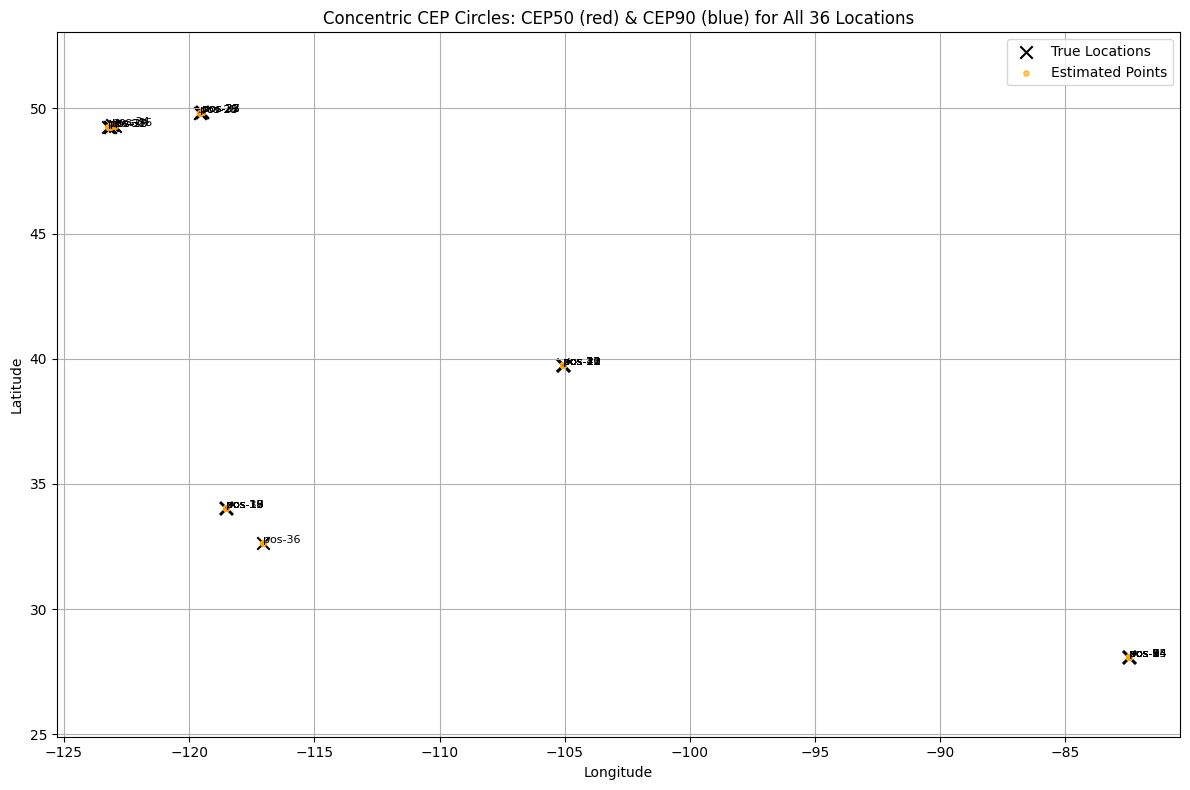

In [ ]:
import matplotlib.pyplot as plt

# Assume the following variables are already defined:
#   - ground_truth: dict mapping "pos-#" → (true_lat, true_lon)
#   - circle_coords: dict mapping "pos-#" → {"cep50": (lat_list, lon_list), "cep90": (lat_list, lon_list)}
#   - all_estimated: list of tuples (location_label, est_lat, est_lon)

plt.figure(figsize=(12, 8))

# Plot each location’s concentric CEP circles
for loc, (true_lat, true_lon) in ground_truth.items():
    if loc not in circle_coords:
        continue

    cep50_lats, cep50_lons = circle_coords[loc]["cep50"]
    cep90_lats, cep90_lons = circle_coords[loc]["cep90"]

    # Large blue circle = CEP90
    plt.plot(cep90_lons, cep90_lats, color="blue", linewidth=1, alpha=0.4)

    # Small red circle = CEP50
    plt.plot(cep50_lons, cep50_lats, color="red", linewidth=1, alpha=0.6)

# Optionally, plot true locations as black "×"
true_lats = [coord[0] for coord in ground_truth.values()]
true_lons = [coord[1] for coord in ground_truth.values()]
plt.scatter(true_lons, true_lats, marker="x", color="black", s=80, label="True Locations")

# Optionally, plot all estimated points as small orange dots
est_lats = [pt[1] for pt in all_estimated]
est_lons = [pt[2] for pt in all_estimated]
plt.scatter(est_lons, est_lats, marker="o", color="orange", s=15, alpha=0.6, label="Estimated Points")

# Annotate each true location with its pos-# label
for loc, (lat, lon) in ground_truth.items():
    plt.text(lon + 0.0002, lat + 0.0002, loc, fontsize=8)

plt.title("Concentric CEP Circles: CEP50 (red) & CEP90 (blue) for All 36 Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.grid(True)
plt.axis("equal")  # Ensure circles remain circular

plt.tight_layout()
plt.show()

## Data for visualization

In [ ]:
import folium

coordsDavid = [
    # # --- position1 (David) ---

    (39.73804089, -105.0775732),  # img_1
    (39.73791503, -105.0777002),  # img_2
    (39.73802503, -105.0777335),  # img_3
    (39.7379399,  -105.0775544),  # img_4
    (39.738028, -105.077672),     # target

    # --- position2 (David) ---

    (39.73701311, -105.0795889),  # img_1
    (39.73686557, -105.0796749),  # img_2
    (39.73678023, -105.0797172),  # img_3
    (39.73694564, -105.0795183),  # img_4
    (39.736929,   -105.079601),   # target

    # --- position3 (David) ---

    (34.04091758,  -118.5355215), # img_1
    (34.04092585,  -118.5355166), # img_2
    (34.04112078,  -118.5353886), # img_3
    (34.04117825,  -118.5353484), # img_4
    (34.0411,      -118.535355),  # target

    # --- position4 (David) ---

    (39.73666803, -105.0803523),  # img_1
    (39.7365907,  -105.0807019),  # img_2
    (39.73682027, -105.0806487),  # img_3
    (39.73681666, -105.0806316),  # img_4
    (39.736659,   -105.080599),   # target

    # --- position5 (David) ---

    (28.07670172, -82.46638443),  # img_1
    (28.07677517, -82.46606034),  # img_2
    (28.0767825,  -82.46605152),  # img_3
    (28.0766182,  -82.4659701),   # img_4
    (28.076706,   -82.46598),     # target

    # --- position6 (David) ---

    (28.07585097, -82.46535757),  # img_1
    (28.07584334, -82.46536353),  # img_2
    (28.07600418, -82.46549801),  # img_3
    (28.07617434, -82.4653046),   # img_4
    (28.075868,   -82.465298),    # target

]

coordsTracy = [
    # --- Position 1 (4 images) ---
    (39.738040888995, -105.077573165938),  # Pos-1, Image: 0891
    (39.737917243148, -105.077699520497),  # Pos-1, Image: 0896
    (39.738028786723, -105.077727662722),  # Pos-1, Image: 0899
    (39.737940366676, -105.077555323044),  # Pos-1, Image: 0903

    # --- Position 2 (4 images) ---
    (39.737018926425, -105.079587737421),  # Pos-2, Image: 0836
    (39.736870385280, -105.079670238295),  # Pos-2, Image: 0839
    (39.736789532172, -105.079682520240),  # Pos-2, Image: 0847
    (39.736949506623, -105.079476261782),  # Pos-2, Image: 0850

    # --- Position 3 (4 images) ---
    (34.040924663186, -118.535496122299),  # Pos-3, Image: 0021
    (34.040932787744, -118.535490780361),  # Pos-3, Image: 0022
    (34.041123880308, -118.535354716480),  # Pos-3, Image: 0023
    (34.041195305722, -118.535354166567),  # Pos-3, Image: 0053

    # --- Position 4 (4 images) ---
    (39.736666944732, -105.080350039690),  # Pos-4, Image: 0824
    (39.736604478051, -105.080717752414),  # Pos-4, Image: 0826
    (39.736832895337, -105.080656826974),  # Pos-4, Image: 0828
    (39.736828926488, -105.080639902035),  # Pos-4, Image: 0829

    # # --- Position 5 (4 images) ---
    # (28.076696871212, -82.466376788619),   # Pos-5, Image: 0635
    # (28.076782506880, -82.466065721858),   # Pos-5, Image: 0637
    # (28.076789966518, -82.466057047930),   # Pos-5, Image: 0638
    # (28.076626945070, -82.465972398564),   # Pos-5, Image: 0639

        # --- Position 5 (4 images) ---
    (28.076704054304, -82.466388325238),   # Pos-5, Image: 0635
    (28.07678250688, -82.466065721858),   # Pos-5, Image: 0637
    (28.076789966518, -82.46605704793),   # Pos-5, Image: 0638
    (28.07662694507, -82.465972398564),   # Pos-5, Image: 0639


    # --- Position 6 (4 images) ---
    (28.075850968124, -82.465357570904),   # Pos-6, Image: 0643
    (28.075843454912, -82.465361720196),   # Pos-6, Image: 0644
    (28.076006723070, -82.465504104477),   # Pos-6, Image: 0647
    (28.076175680994, -82.465303850198)    # Pos-6, Image: 0656
]

# Function to extract a position slice (each position has 5 coordinates)
def get_position_slice(coords, pos_name,items_per_position):
    """
    Given the coords list and pos_name (e.g., "Pos-1"), return the slice of 5 coordinates.
    """
    # Assume pos_name format "Pos-X" where X is 1-indexed
    pos_number = int(pos_name.split("-")[1])
    start = (pos_number - 1) * items_per_position
    end = start + items_per_position
    return coords[start:end]

## Compare

In [ ]:
from folium.plugins import MarkerCluster

desired_position = "Pos-5"
david_slice = get_position_slice(coordsDavid, desired_position, items_per_position=5)
victor_slice = get_position_slice(coordsVictor, desired_position, items_per_position=4)


image_names = ["image1", "image2", "image3", "image4","target"]
center_lat, center_lon = david_slice[0]
m = folium.Map(location=[center_lat, center_lon], zoom_start=20)
# marker_cluster = MarkerCluster().add_to(m)
offsets = [0, 0.00001, -0.00001, 0.00002, -0.00002]
for i, (lat, lon) in enumerate(david_slice):
    color = "red" if i == 4 else "blue"
    folium.Marker(
        location=[lat, lon],
        popup=f"David {image_names[i]}",
        icon=folium.Icon(color=color)
    ).add_to(m)


for i, (lat, lon) in enumerate(week26_slice):
    folium.Marker(
        location=[lat + offsets[i], lon + offsets[i]],
        popup=f"Week26 {image_names[i]}",
        icon=folium.Icon(color="green")
    ).add_to(m)

file_name = f"map_{desired_position}.html"
m.save(file_name)
m